In [1]:
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import os

In [3]:

# Set Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Base Directory and Paths
BASE_DIR = '/kaggle/input/data/'
IMAGE_DIRECTORY = BASE_DIR + 'training_images'
ANNOTATIONS_FILE = BASE_DIR + 'train_solution_bounding_boxes (1).csv'

# Load Annotations
bounding_boxes_df = pd.read_csv(ANNOTATIONS_FILE)
bounding_boxes_df.rename(columns={'image': 'ImageID'}, inplace=True)
print("Bounding Box Annotations Loaded:")
print(bounding_boxes_df.head())


Bounding Box Annotations Loaded:
           ImageID        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422


In [5]:
# Train-Validation Split
train_image_ids, val_image_ids = train_test_split(
    bounding_boxes_df['ImageID'].unique(),
    test_size=0.1,
    random_state=99
)

train_df = bounding_boxes_df[bounding_boxes_df['ImageID'].isin(train_image_ids)]
val_df = bounding_boxes_df[bounding_boxes_df['ImageID'].isin(val_image_ids)]

print(f"Training DataFrame size: {len(train_df)}, Validation DataFrame size: {len(val_df)}")
print(f"Image Root Directory: {IMAGE_DIRECTORY}")

Training DataFrame size: 501, Validation DataFrame size: 58
Image Root Directory: /kaggle/input/data/training_images


In [6]:
# Label to Target Mapping
label2target = {'background': 0, 'car': 1}
target2label = {v: k for k, v in label2target.items()}
NUM_CLASSES = len(label2target)
print(f"Number of Classes: {NUM_CLASSES}")

Number of Classes: 2


In [7]:
import torch

# Function to Preprocess Image
def preprocess_image(image):
    """
    Preprocess image for the model.
    """
    image_tensor = torch.tensor(image).permute(2, 0, 1)  # HWC to CHW
    return image_tensor.to(DEVICE, dtype=torch.float32)

# Function to map filenames to their full paths
def map_files_to_paths(file_paths):
    """
    Maps filenames to their full paths.
    Args:
        file_paths (list): List of file paths.
    Returns:
        dict: Dictionary where keys are filenames and values are their full paths.
    """
    path_mapping = {file_path.split('/')[-1]: file_path for file_path in file_paths}
    return path_mapping


In [8]:
# Custom Dataset Class
class OpenDataset(Dataset):
    def __init__(self, df, image_dir):
        self.image_size = (224, 224)
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir + '/*')
        self.df = df.copy()
        self.image_ids = df['ImageID'].unique()
        self.image_path_map = self._create_image_path_map(self.files)

    def _create_image_path_map(self, file_paths):
        return {path.split('/')[-1]: path for path in file_paths}

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = self.image_path_map[image_id]
        
        # Load Image and Bounding Boxes
        image = Image.open(img_path).convert("RGB")
        image_data = self.df[self.df['ImageID'] == image_id]
        original_width, original_height = image.size

        # Normalize and Scale Bounding Boxes
        boxes = image_data[['xmin', 'ymin', 'xmax', 'ymax']].values
        boxes[:, [0, 2]] /= original_width
        boxes[:, [1, 3]] /= original_height

        image = image.resize(self.image_size, resample=Image.BILINEAR)
        boxes[:, [0, 2]] *= self.image_size[0]
        boxes[:, [1, 3]] *= self.image_size[1]
        boxes = boxes.astype(np.uint32).tolist()

        labels = [label2target['car']] * len(boxes)
        target = {"boxes": torch.tensor(boxes, dtype=torch.float32),
                  "labels": torch.tensor(labels, dtype=torch.int64)}

        image = np.array(image) / 255.0
        image_tensor = torch.tensor(image).permute(2, 0, 1).float()

        return image_tensor, target

    def collate_fn(self, batch):
        images, targets = zip(*batch)
        return list(images), list(targets)

    def __len__(self):
        return len(self.image_ids)

In [9]:
# Create DataLoader
train_ds = OpenDataset(train_df, IMAGE_DIRECTORY)
val_ds = OpenDataset(val_df, IMAGE_DIRECTORY)

train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=2, collate_fn=val_ds.collate_fn, shuffle=False, drop_last=True, num_workers=2)

# Verify DataLoader
print("\n--- Verifying Training DataLoader ---")
for images, targets in train_loader:
    print(f"Batch Size: {len(images)}")
    print(f"Image Shape: {images[0].shape}")
    print(f"Sample Target: {targets[0]}")
    break


--- Verifying Training DataLoader ---
Batch Size: 2
Image Shape: torch.Size([3, 224, 224])
Sample Target: {'boxes': tensor([[ 70., 114., 100., 136.],
        [  3., 115.,  20., 131.]]), 'labels': tensor([1, 1])}


In [10]:
# Load Faster R-CNN Model (ResNet50-FPN v2)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)

# Update the box_predictor to match the number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features  # Input features for classification head
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features,  # Number of input channels
    NUM_CLASSES   # Number of classes: background + car
)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                             weight_decay=0.0005)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 95.4MB/s] 


In [11]:
def train_batch(inputs, model, optimizer):
    """
    Perform a single training batch step.

    Args:
        inputs (tuple): Tuple containing a batch of images and targets.
        model (torch.nn.Module): Faster R-CNN model for training.
        optimizer (torch.optim.Optimizer): Optimizer for model updates.

    Returns:
        tuple: Total loss and a dictionary of individual losses.
    """
    model.train()  # Set model to training mode
    images, targets = inputs  # Unpack images and targets
    images = [image.to(DEVICE) for image in images]  # Move images to DEVICE (GPU/CPU)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]  # Move targets to DEVICE

    optimizer.zero_grad()  # Zero gradients
    losses = model(images, targets)  # Forward pass to compute losses
    total_loss = sum(loss for loss in losses.values())  # Sum of all losses

    total_loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters

    return total_loss, losses


@torch.no_grad()  # Disable gradient computation
def validate_batch(inputs, model):
    """
    Perform a single validation batch step.

    Args:
        inputs (tuple): Tuple containing a batch of images and targets.
        model (torch.nn.Module): Faster R-CNN model for validation.

    Returns:
        tuple: Total loss and a dictionary of individual losses.
    """
    model.train()  # Keep the model in train mode to compute losses
    images, targets = inputs  # Unpack images and targets
    images = [image.to(DEVICE) for image in images]  # Move images to DEVICE (GPU/CPU)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]  # Move targets to DEVICE

    losses = model(images, targets)  # Forward pass to compute losses
    total_loss = sum(loss for loss in losses.values())  # Sum of all losses

    return total_loss, losses


In [17]:
import matplotlib.pyplot as plt

# Lists to store training and validation loss values
train_losses = []
valid_losses = []

# Training and Validation Loop
n_epochs = 2
best_valid_loss = float("inf")
patience = 8  # Number of epochs to wait for improvement
patience_counter = 0

# Loop through epochs
for epoch in range(n_epochs):
    print(f"\n--- Epoch {epoch + 1}/{n_epochs} ---")

    # Training phase
    model.train()
    total_train_loss = 0
    for inputs in train_loader:  # Training loader
        loss, _ = train_batch(inputs, model, optimizer)
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Append training loss
    print(f"Training Loss for Epoch {epoch + 1}: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    total_valid_loss = 0
    with torch.no_grad():
        for inputs in val_loader:  # Validation loader
            loss, _ = validate_batch(inputs, model)
            total_valid_loss += loss.item()

    avg_valid_loss = total_valid_loss / len(val_loader)
    valid_losses.append(avg_valid_loss)  # Append validation loss
    print(f"Validation Loss for Epoch {epoch + 1}: {avg_valid_loss:.4f}")

    # Save the best model
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), "best_fasterrcnn_model.pt")
        patience_counter = 0
        print(f"Best model saved with Validation Loss: {best_valid_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience counter: {patience_counter}/{patience}")

    # Early stopping
    if patience_counter >= patience:
        print("\nEarly stopping triggered!")
        break

# Load the best model after training
model.load_state_dict(torch.load("best_fasterrcnn_model.pt"))
print("\nTraining complete. Best model loaded.")


--- Epoch 1/2 ---
Training Loss for Epoch 1: 0.1127
Validation Loss for Epoch 1: 0.1296
Best model saved with Validation Loss: 0.1296

--- Epoch 2/2 ---
Training Loss for Epoch 2: 0.0905
Validation Loss for Epoch 2: 0.1224
Best model saved with Validation Loss: 0.1224

Training complete. Best model loaded.


/tmp/ipykernel_23/466551326.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_fasterrcnn_model.pt"))


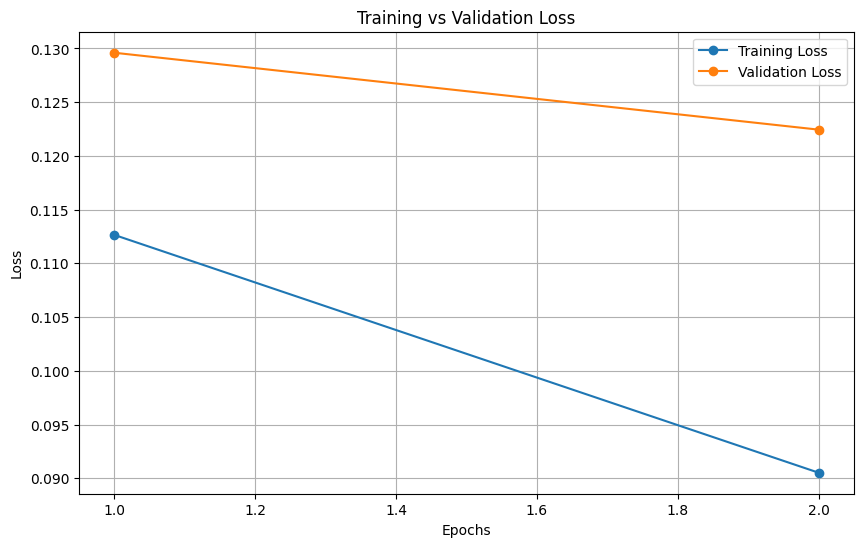

In [18]:
# Plot Training vs Validation Loss
def plot_losses(train_losses, valid_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss", marker='o')
    plt.plot(epochs, valid_losses, label="Validation Loss", marker='o')

    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Call the plot function
plot_losses(train_losses, valid_losses)

In [13]:
import numpy as np
import torch
import cv2
from torchvision.ops import nms

# Function to decode model outputs
def decode_output(output, index_to_class, iou_threshold=0.05):
    """
    Convert model output tensors to bounding boxes, confidence scores, and labels.

    Parameters:
    - output: Model output dictionary with 'boxes', 'labels', and 'scores'.
    - index_to_class: Mapping from class indices to class labels.
    - iou_threshold: Non-Maximum Suppression (NMS) IoU threshold.

    Returns:
    - bbs: List of bounding boxes.
    - confs: List of confidence scores.
    - labels: List of class labels.
    """
    # Extract tensors and convert to numpy
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([index_to_class[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()

    # Apply Non-Maximum Suppression (NMS)
    indices = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), iou_threshold)
    bbs, confs, labels = [tensor[indices] for tensor in [bbs, confs, labels]]

    # Handle case with only one bounding box
    if len(indices) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]

    return bbs.tolist(), confs.tolist(), labels.tolist()


# Function to plot bounding boxes, confidence scores, and labels
def plot_bbs_confs_labels(image, bbs, confs, labels, label_colors=None):
    """
    Plot bounding boxes, confidence scores, and labels on an image.

    Parameters:
    - image: The image on which to plot (numpy array).
    - bbs: List of bounding boxes, each in the form [x_min, y_min, x_max, y_max].
    - confs: List of confidence scores for each bounding box.
    - labels: List of labels for each bounding box.
    - label_colors: Optional dictionary mapping labels to colors.

    Returns:
    - Image with bounding boxes, confidence scores, and labels plotted.
    """
    image_with_bbs = image.copy()

    # Default color map if not provided
    if label_colors is None:
        label_colors = {"car": (0, 255, 0)}  # Default: green for cars

    for bb, conf, label in zip(bbs, confs, labels):
        x_min, y_min, x_max, y_max = bb
        color = label_colors.get(label, (0, 255, 0))  # Use label color or default

        # Draw bounding box
        cv2.rectangle(image_with_bbs, (x_min, y_min), (x_max, y_max), color, 2)

        # Prepare label text
        text = f"{label}: {conf:.2f}"
        (text_width, text_height), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1
        )

        # Draw label background
        cv2.rectangle(image_with_bbs, (x_min, y_min - text_height - baseline), 
                      (x_min + text_width, y_min), color, cv2.FILLED)

        # Put label text
        cv2.putText(
            image_with_bbs, text, (x_min, y_min - baseline),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1
        )

    return image_with_bbs


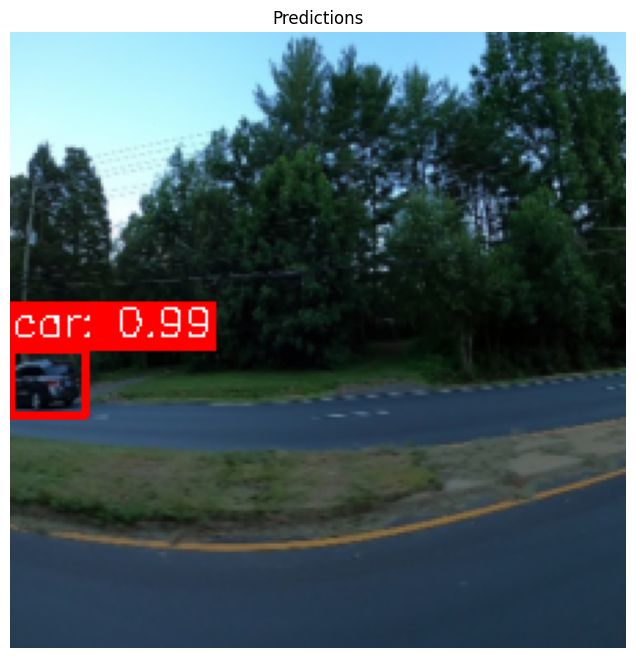

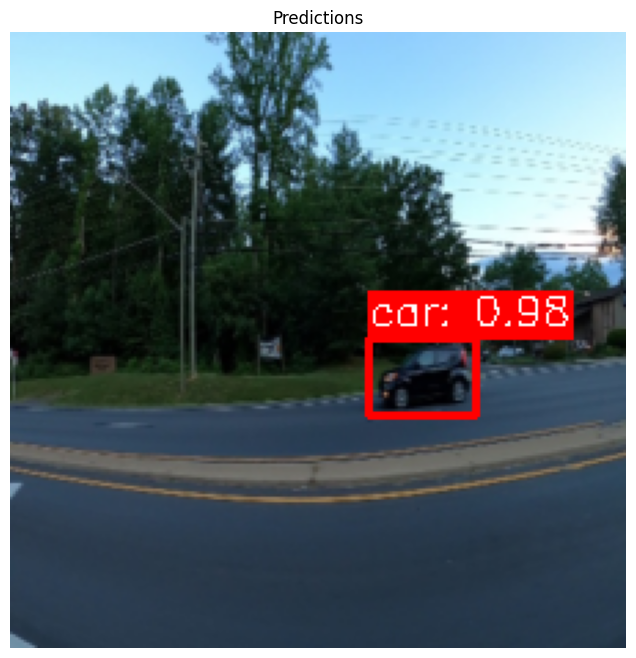

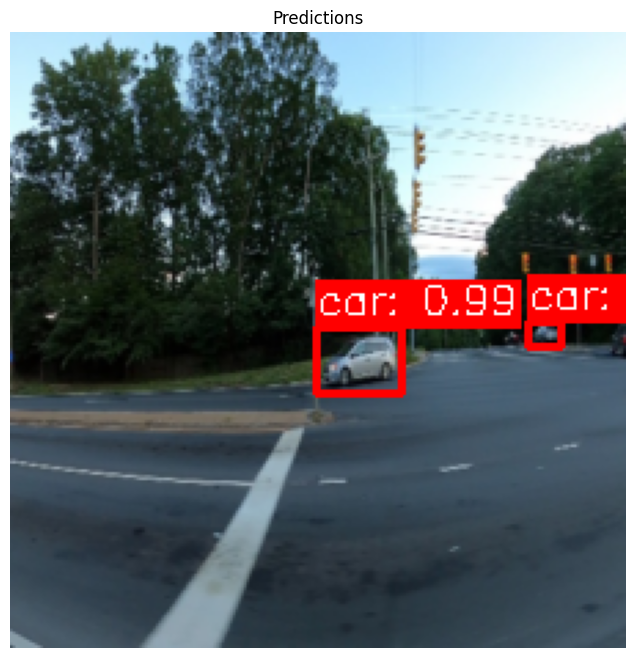

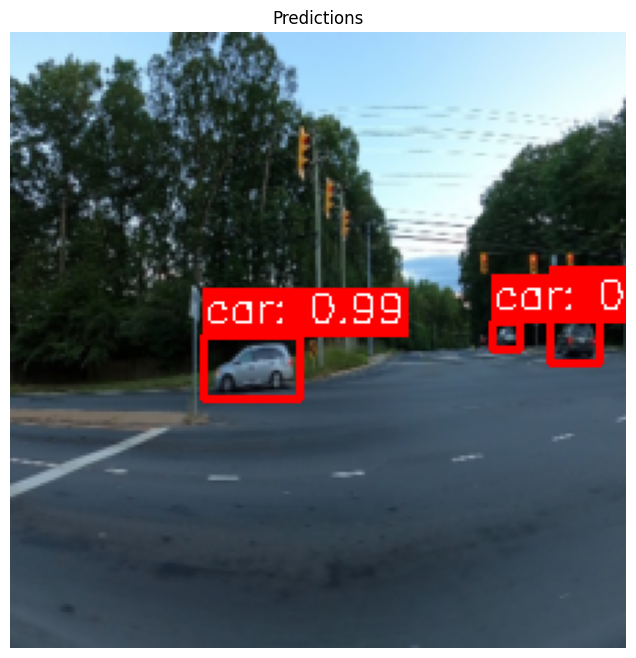

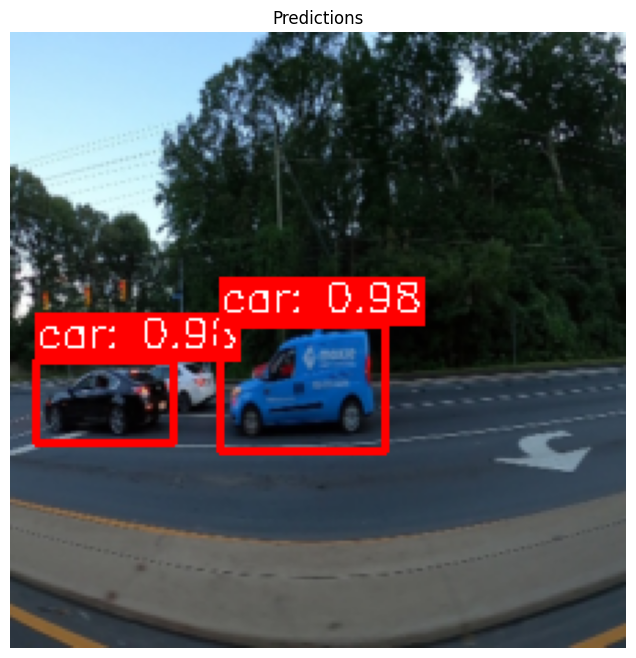

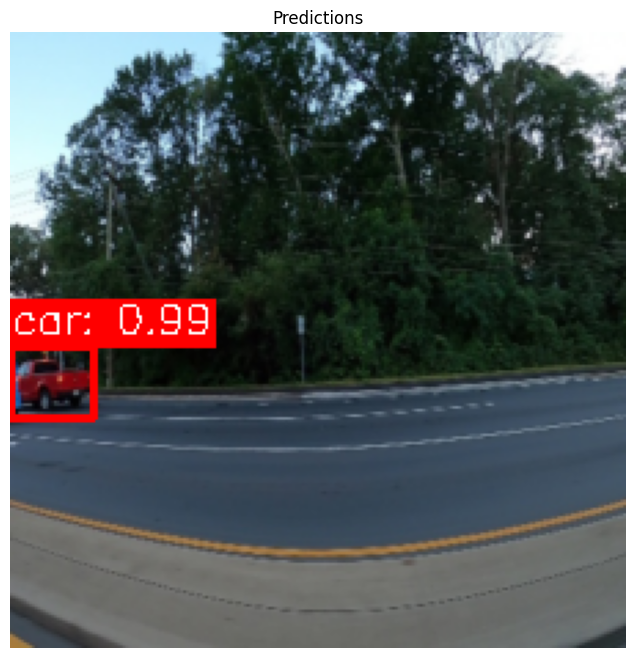

In [16]:
model.eval()  # Set the model to evaluation mode

# Iterate over the validation DataLoader
for batch_idx, (images, targets) in enumerate(val_loader):
    if batch_idx == 3:  # Stop after 3 batches
        break

    # Prepare images for inference
    images = [img.to(DEVICE) for img in images]  # Move images to device (GPU/CPU)
    outputs = model(images)  # Get predictions from the model
    
    # Optional: Custom colors for labels
    label_colors = {'car': (255, 0, 0)}  # Red for 'car'
    
    # Process each output in the batch
    for img_idx, output in enumerate(outputs):
        # Decode predictions
        bbs, confs, labels = decode_output(output, target2label)

        # Convert image tensor to numpy and denormalize
        image_np = images[img_idx].cpu().permute(1, 2, 0).numpy()  # CHW -> HWC
        image_np = (image_np * 255).astype(np.uint8)  # Convert from [0, 1] to [0, 255]

        # Plot bounding boxes, confidence scores, and labels
        image_with_bbs = plot_bbs_confs_labels(image_np, bbs, confs, labels, label_colors)

        # Display the image with bounding boxes
        plt.figure(figsize=(10, 8))
        plt.imshow(image_with_bbs)
        plt.axis('off')
        plt.title("Predictions")
        plt.show()
